# Text Classification using BERT


### Scenario-Based Problem Statement:

You are working for a news aggregation platform that wants to automatically categorize news articles into different topics. Your task is to build a text classification model using BERT, a state-of-the-art NLP model, to categorize news articles into one of five predefined categories: Business, Entertainment, Sport, Tech, and Politics. You are provided with a dataset in the "bbc-text.csv" file, which contains news articles along with their corresponding categories.

### Step 1: Importing the Required Libraries for Working with Bert and Training a Bert-Based Model


In [1]:
# Install the 'transformers' library using pip
#pip install transformers

import pandas as pd # Importing pandas for data manipulation
import torch  # Importing PyTorch, a popular deep learning framework
import numpy as np # Importing NumPy, a library for numerical operations
from transformers import BertTokenizer, BertModel  # Importing components from the transformers library
import torch.nn as nn # Importing PyTorch's neural network module
from torch.optim import Adam # Importing the Adam optimizer from PyTorch
from tqdm import tqdm # Importing tqdm for progress tracking during training

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Step 2: Reading and Previewing Data from a CSV File Using Pandas


In [2]:
#datapath = f'/content/drive/My Drive/Medium/bbc-text.csv'
# Read a CSV file named "bbc-text.csv" into a Pandas DataFrame
df = pd.read_csv("bbc-text.csv")

# Display the first few rows of the DataFrame to inspect the data
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


**Observation:**

The code reads a CSV file named **bbc-text.csv** from the specified path and displays the first few rows of the dataset.

### Step 3: Visualizing Category Distribution with a Bar Chart

<Axes: xlabel='category'>

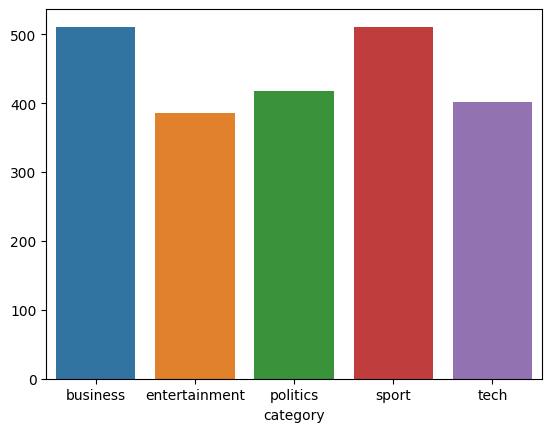

In [3]:
# Group the DataFrame 'df' by the 'category' column and count the occurrences of each category
num_categories = df.groupby(['category']).count()

# Create a bar plot to visualize the count of each category
sns.barplot(data=num_categories.T)

**Record Observation:**


### Step 4: Customizing Dataset Class for Text Classification with BERT Tokenization

In [4]:
# Import the BERT tokenizer from the 'transformers' library
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Define a dictionary 'labels' to map category names to numerical labels
labels = {'business': 0, 'entertainment': 1, 'politics' : 2, 'sport' : 3, 'tech' : 4}

# Create a custom dataset class named 'Dataset'
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        # Initialize the class with a DataFrame 'df'
        self.df = df

        # Create a list 'labels' containing numerical labels for each category in the DataFrame
        self.labels = [labels[label] for label in df['category']]

        # Tokenize and preprocess the text data using the BERT tokenizer
        # Store the tokenized texts in a list 'self.texts'
        self.texts = [tokenizer(text,
                                padding='max_length', max_length=512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        # Return the list of numerical labels
        return self.labels

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.df)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels for a given index 'idx'
        return torch.tensor(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of tokenized texts for a given index 'idx'
        return self.texts[idx]

    def __getitem__(self, idx):
        # Fetch a batch of tokenized texts and labels for a given index 'idx'
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


**Record Observation:**


### Step 5: Fine-tuning BERT for Text Classification


In [5]:
# Define a custom BERT-based classifier class
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        # Constructor method for initializing the classifier
        super(BertClassifier, self).__init__()  # Call the constructor of the parent class

        # Load the pre-trained BERT model ('bert-base-cased') as the backbone
        self.bert = BertModel.from_pretrained('bert-base-cased')

        # Define a dropout layer with a specified dropout rate
        self.dropout = nn.Dropout(dropout)

        # Define a linear (fully connected) layer with 768 input features (BERT hidden size) and 5 output features (for 5 classes)
        self.linear = nn.Linear(768, 5)

        # Define a ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        # Forward pass method for the classifier

        # Pass the input token IDs and attention mask through the BERT model
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)

        # Apply dropout to the pooled output
        dropout_output = self.dropout(pooled_output)

        # Pass the dropout output through the linear layer
        linear_output = self.linear(dropout_output)

        # Apply the ReLU activation function to the linear output
        final_layer = self.relu(linear_output)

        # Return the final classification layer output
        return final_layer

### Step 6: Training and Validation Loop for BERT-based Classifier

In [6]:
# Define a training function that takes the model, training data, validation data, learning rate, and number of epochs as inputs
def train(model, train_data, val_data, learning_rate, epochs):

    # Create Dataset objects for the training and validation data
    train_dataset = Dataset(train_data)
    val_dataset = Dataset(val_data)

    # Create data loaders for the training and validation data
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

    # Check if a CUDA-enabled GPU is available and set the device accordingly
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    #device = torch.device('cpu')  # Force to CPU for debugging

    # Define the loss function (CrossEntropyLoss) and the optimizer (Adam)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Move the model and criterion to the GPU if available
    if use_cuda:
        model = model.to(device)
        criterion = criterion.to(device)

    # Loop over the specified number of training epochs
    for epoch_num in range(epochs):

        # Initialize variables to keep track of training statistics for this epoch
        total_acc_train = 0
        total_loss_train = 0

        # Loop over the training data in batches
        for train_input, train_label in tqdm(train_dataloader):

            # Move the batch data and labels to the GPU if available
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            # Forward pass through the model
            output = model(input_id, mask)

            # Compute the batch loss using CrossEntropyLoss
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            # Compute the batch accuracy
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # Zero the gradients, perform backpropagation, and update the model's weights
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # Initialize variables to keep track of validation statistics for this epoch
        total_acc_val = 0
        total_loss_val = 0

        # Disable gradient computation for the validation phase
        with torch.no_grad():

            # Loop over the validation data in batches
            for val_input, val_label in val_dataloader:

                # Move the batch data and labels to the GPU if available
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                # Forward pass through the model
                output = model(input_id, mask)

                # Compute the batch loss using CrossEntropyLoss
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                # Compute the batch accuracy
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        # Print the training and validation statistics for this epoch
        print(f'Epoch {epoch_num + 1}/{epochs}')
        print(f'Train Loss: {total_loss_train / len(train_dataloader):.4f} | Train Accuracy: {total_acc_train / len(train_dataset):.4f}')
        print(f'Val Loss: {total_loss_val / len(val_dataloader):.4f} | Val Accuracy: {total_acc_val / len(val_dataset):.4f}')

### Step 7: Implementing Function for Model Evaluation

In [7]:
# Define an evaluation function that takes the model and test data as inputs
def evaluate(model, test_data):

    # Create a Dataset object for the test data
    test_dataset = Dataset(test_data)

    # Create a data loader for the test data
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

    # Check if a CUDA-enabled GPU is available and set the device accordingly
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    #device = torch.device('cpu')  # Force to CPU for debugging

    # Move the model to the GPU if available
    if use_cuda:
        model = model.to(device)

    # Initialize a variable to keep track of the total accuracy on the test data
    total_acc_test = 0

    # Disable gradient computation for the evaluation phase
    with torch.no_grad():

        # Loop over the test data in batches
        for test_input, test_label in tqdm(test_dataloader):

            # Move the batch data and labels to the GPU if available
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            # Forward pass through the model
            output = model(input_id, mask)

            # Compute the batch accuracy
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    # Calculate the total accuracy as a percentage
    test_accuracy = total_acc_test / len(test_dataset)

    # Print the test accuracy
    print(f'Test Accuracy: {test_accuracy:.4f}')


### Step 8: Splitting the Dataset

In [8]:
# Set a random seed to ensure reproducibility
np.random.seed(112)

# Shuffle the rows of the DataFrame 'df' using a random seed and split it into three parts: train, validation, and test
# The split ratios are 80% for training, 10% for validation, and 10% for testing
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=112, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=112, shuffle=True)

# Print the lengths of the training, validation, and test sets to verify the split
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Test set size: {len(test_df)}')


Training set size: 1780
Validation set size: 222
Test set size: 223


**Record Observation:**


### Step 9: Training the Model

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# Define the number of training epochs as 5
EPOCHS = 5

# Create an instance of the BertClassifier model
model = BertClassifier()

# Define the learning rate
LR = 1e-6

# Call the 'train' function to train the model on the training data with the specified learning rate and number of epochs
train(model, train_df, val_df, LR, EPOCHS)

  0%|          | 0/56 [00:00<?, ?it/s]c:\Users\arado\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 56/56 [07:57<00:00,  8.52s/it]


Epoch 1/5
Train Loss: 1.6303 | Train Accuracy: 0.2382
Val Loss: 1.5856 | Val Accuracy: 0.2523


100%|██████████| 56/56 [07:56<00:00,  8.51s/it]


Epoch 2/5
Train Loss: 1.5062 | Train Accuracy: 0.3596
Val Loss: 1.4501 | Val Accuracy: 0.4324


100%|██████████| 56/56 [07:56<00:00,  8.50s/it]


Epoch 3/5
Train Loss: 1.4105 | Train Accuracy: 0.4663
Val Loss: 1.4154 | Val Accuracy: 0.4369


100%|██████████| 56/56 [07:56<00:00,  8.50s/it]


Epoch 4/5
Train Loss: 1.3063 | Train Accuracy: 0.5438
Val Loss: 1.2520 | Val Accuracy: 0.5811


100%|██████████| 56/56 [07:56<00:00,  8.50s/it]


Epoch 5/5
Train Loss: 1.1917 | Train Accuracy: 0.5843
Val Loss: 1.1668 | Val Accuracy: 0.5991


**Record Observation:**


### Step 10: Evaluating the Model

In [12]:
# Call the 'evaluate' function to evaluate the trained model on the test data
evaluate(model, test_df)

100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

Test Accuracy: 0.6054


# Observation : 
## I could get a higher accuracy, but the BERT Model is so large, that training on my machine takes ~8 minutes per epoch. Therefore, I will accept a low test accuacy for this experiment. 